In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import gutenberg
import re
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.decomposition import NMF

import os
from os import walk

%matplotlib inline

In [2]:
# Linking words to topics
def word_topic(tfidf,solution, wordlist):
    
    # Loading scores for each word on each topic/component.
    words_by_topic=tfidf.T * solution

    # Linking the loadings to the words in an easy-to-read way.
    components=pd.DataFrame(words_by_topic,index=wordlist)
    
    return components

# Extracts the top N words and their loadings for each topic.
def top_words(components, n_top_words):
    n_topics = range(components.shape[1])
    index= np.repeat(n_topics, n_top_words, axis=0)
    topwords=pd.Series(index=index)
    for column in range(components.shape[1]):
        # Sort the column so that highest loadings are at the top.
        sortedwords=components.iloc[:,column].sort_values(ascending=False)
        # Choose the N highest loadings.
        chosen=sortedwords[:n_top_words]
        # Combine loading and index into a string.
        chosenlist=chosen.index +" "+round(chosen,2).map(str) 
        topwords.loc[column]=[x for x in chosenlist]
    return(topwords)

# Number of words to look at for each topic.
n_top_words = 10

# Comparing LSA, LDA, and NNMF

Now that you've been introduced to the logic behind these three topic extraction methods, we're going to try them out on the *Emma* corpus.  We'll be looking at interpretability, speed, and consistency across methods.  The goal is to identify common themes in *Emma* on a per-paragraph basis.  We won't be using pLSA as sklearn does not support it.

To do this, we will:

1. Parse and process the data into a tf-idf matrix.
2. Fit LSA, LDA, and NNMF models with 5 topics each.
4. Extract the words that best describe each topic.
5. Examine the topic relationships for the words 'marriage', 'love', and 'Emma.'

## Generating the tfidf matrix

In [ ]:
# Processing the data.

from nltk.corpus import gutenberg
import re
from sklearn.feature_extraction.text import TfidfVectorizer


#reading in the data, this time in the form of paragraphs
emma=gutenberg.paras('austen-emma.txt')
#processing
emma_paras=[]
for paragraph in emma:
    para=paragraph[0]
    #removing the double-dash from all words
    para=[re.sub(r'--','',word) for word in para]
    #Forming each paragraph into a string and adding it to the list of strings.
    emma_paras.append(' '.join(para))

# Creating the tf-idf matrix.
vectorizer = TfidfVectorizer(stop_words='english')
emma_paras_tfidf=vectorizer.fit_transform(emma_paras)

# Getting the word list.
terms = vectorizer.get_feature_names()

# Number of topics.
ntopics=5

In addition to creating the tfidf matrix, there are two convenience functions that will help keep the code tidy when comparing models.  The first provides a list of the words that are paired with each topic.  The second gives us the best words for each topic so we can compare across methods.

## Fitting the three topic extraction models

In [98]:
# LSA

from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

svd= TruncatedSVD(ntopics)
lsa = make_pipeline(svd, Normalizer(copy=False))
emma_paras_lsa = lsa.fit_transform(emma_paras_tfidf)

components_lsa = word_topic(emma_paras_tfidf, emma_paras_lsa, terms)

topwords=pd.DataFrame()
topwords['LSA']=top_words(components_lsa, n_top_words)                


In [99]:
# LDA
from sklearn.decomposition import LatentDirichletAllocation as LDA

lda = LDA(n_components=ntopics, #<--I had to change this from "n_topics" because that generated an error: TypeError: __init__() got an unexpected keyword argument 'n_topics'
          doc_topic_prior=None, # Prior = 1/n_documents
          topic_word_prior=1/ntopics,
          learning_decay=0.7, # Convergence rate.
          learning_offset=10.0, # Causes earlier iterations to have less influence on the learning
          max_iter=10, # when to stop even if the model is not converging (to prevent running forever)
          evaluate_every=-1, # Do not evaluate perplexity, as it slows training time.
          mean_change_tol=0.001, # Stop updating the document topic distribution in the E-step when mean change is < tol
          max_doc_update_iter=100, # When to stop updating the document topic distribution in the E-step even if tol is not reached
          n_jobs=-1, # Use all available CPUs to speed up processing time.
          verbose=0, # amount of output to give while iterating
          random_state=0
         )

emma_paras_lda = lda.fit_transform(emma_paras_tfidf) 

components_lda = word_topic(emma_paras_tfidf, emma_paras_lda, terms)

topwords['LDA']=top_words(components_lda, n_top_words)


In [100]:
# NNMF

from sklearn.decomposition import NMF

nmf = NMF(alpha=0.0, 
          init='nndsvdar', # how starting value are calculated
          l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
          max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
          n_components=ntopics, 
          random_state=0, 
          solver='cd', # Use Coordinate Descent to solve
          tol=0.0001, # model will stop if tfidf-WH <= tol
          verbose=0 # amount of output to give while iterating
         )
emma_paras_nmf = nmf.fit_transform(emma_paras_tfidf) 

components_nmf = word_topic(emma_paras_tfidf, emma_paras_nmf, terms)

topwords['NNMF']=top_words(components_nmf, n_top_words)

We are mostly using the default settings for each method, but explicitly printing them so it is clear what is going on and how each model can be modified.  sklearn has such nice parallel structure for its various topic extraction methods that we could probably have abstracted the code even further.

# Inspecting the topics

For each topic, we list the ten most-relevant words according to each method:

In [101]:
for topic in range(ntopics):
    print('Topic {}:'.format(topic))
    print(topwords.loc[topic])
    

Topic 0:
              LSA            LDA             NNMF
0        oh 97.61     emma 13.08         oh 30.12
0        yes 4.84  harriet 12.82         yes 0.52
0      thank 1.64       mr 11.55       sorry 0.16
0  difference 1.6     said 10.09  difference 0.15
0       just 1.44        oh 9.99        just 0.12
0    harriet 1.33     think 9.47        papa 0.12
0      sorry 1.28       mrs 8.98        week 0.11
0      short 1.18   chapter 8.69       short 0.11
0       papa 1.15     quite 7.81    recollect 0.1
0      cried 1.02      miss 7.09      letter 0.09
Topic 1:
             LSA          LDA            NNMF
1       mr 58.21     oh 58.33         mr 7.29
1     emma 57.99   emma 19.35        mrs 4.26
1      said 50.3   said 14.65      elton 3.41
1      mrs 47.06    mrs 14.43  knightley 3.24
1     miss 37.72     mr 14.17     weston 3.15
1  harriet 35.18    yes 14.03       miss 2.99
1   weston 32.18    did 10.82  woodhouse 2.09
1     elton 28.2    miss 9.53       said 1.88
1      did 27.61  

A number of things are clear.  First, some topics are shared, though the order of topics varies- the 'oh' topic is first for LSA and NNMF, but second for LDA.  And second, the content of some of the topics varies considerably across methods.  This is a clear argument for using multiple methods when exploring topics.

# Sparsity

Now let's examine sparsity by looking at the distributions of loadings for the words 'marriage', 'love', 'emma', and 'oh' across the methods:

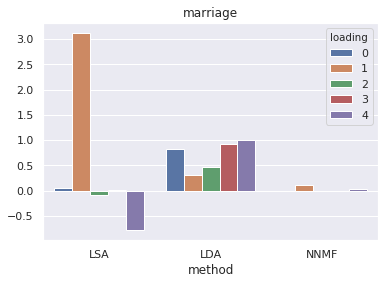

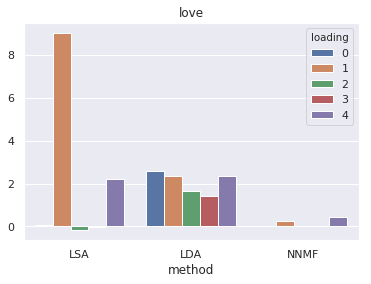

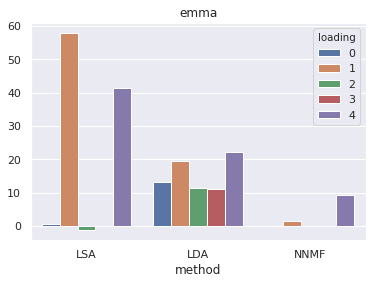

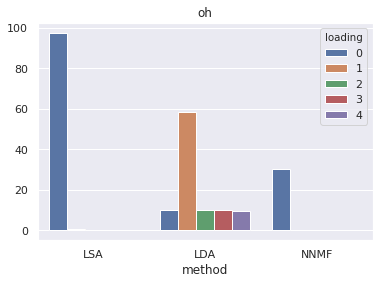

In [102]:
# The words to look at.
targetwords=['marriage','love','emma','oh']

# Storing the loadings.
wordloadings=pd.DataFrame(columns=targetwords)

# For each word, extracting and string the loadings for each method.
for word in targetwords:
    loadings=components_lsa.loc[word].append(
        components_lda.loc[word]).append(
            components_nmf.loc[word])
    wordloadings[word]=loadings

# Labeling the data by method and providing an ordering variable for graphing purposes. 
wordloadings['method']=np.repeat(['LSA','LDA','NNMF'], 5, axis=0)
wordloadings['loading']=[0,1,2,3,4]*3

sns.set(style="darkgrid")

for word in targetwords:
    sns.barplot(x="method", y=word, hue="loading", data=wordloadings)
    plt.title(word)
    plt.ylabel("")
    plt.show()


LSA is the method most likely to have high loadings on more than one topic for the same word.  LDA tends to have one high loading and some lower loadings.  Loadings for NNMF are lower all around, and the most sparse, with some of the topics having loadings of zero on each word.

# Challenge: Topic extraction on new data

### Take the well-known [20 newsgroups](http://qwone.com/~jason/20Newsgroups/) dataset and use each of the methods on it.  Your goal is to determine which method, if any, best reproduces the topics represented by the newsgroups.  Write up a report where you evaluate each method in light of the 'ground truth'- the known source of each newsgroup post.  Which works best, and why do you think this is the case?



First: I needed an external source to make sense of Latent Dirichlet Allocation. [This one wasn't bad](https://towardsdatascience.com/light-on-math-machine-learning-intuitive-guide-to-latent-dirichlet-allocation-437c81220158).

I grabbed the copy of the newsgroup dataset where the headers have been stripped, except for "from" and "subject" lines, which I will also pare down because otherwise I suspect the words "from" and "subject" will end up skewing the results.

The metadata for the newsgroup dataset has already split the posts into six categories. They are not named, but based on the newsgroup names, they are roughly:

* Computers (computer hardware specifically?)
* Sports and Motorsports
* Science and Technology
* Items for Sale
* Politics
* Religion

I'm already a little concerned about how easy it's going to be to tell Computer posts from Science/Tech posts. But let's see.

In [45]:
# Number of newsgroup topics.
ng_topics=6

In [46]:
# Utility function for standard text cleaning.
def text_cleaner(text):
# Newsgroup posters have fancy ASCII signatures (ahh, the late 80s/early 90s).
# Obliterate all of the repetitive punctuation that typifies them.
    text = re.sub(r'[-+=~_/\\|\^%:\.]{2,}',' ',text)
# Remove From lines, and the word "Subject: " when it is at the beginning of a line
    text = re.sub(r'^From.*',' ',text)
    text = re.sub(r'Subject:\s*',' ',text)
# Remove "words" that are nothing but spaces and digits, possibly with embedded parenthesis and dashes
#    text = re.sub(r'\s*[\(\)0-9]+\s*', '', text,flags=re.M)
# (This was a poorly-written rule that ended up eating strings of digits that provided useful information/context)

    text = " ".join(text.split())
    return text

os.walk returns a 3-tuple of path, directory names found under path, file names found under path.

Because walk's default is top-down traversal, index 0 is the top-level directory--the rest of the list represents the subdirectories containing the files we care about.

In [47]:
ng_text = []
ng_name = []
idx = 0
for dirpath, dirlist, filelist in list(walk('/home/jeremy/Documents/Jupyter/20news-18828/'))[1:]:
    this_dir = list(walk('/home/jeremy/Documents/Jupyter/20news-18828/'))[0][1][idx]
    for filename in filelist:
# Read in each file as a new document in ng_posts.
        with open(os.path.join(dirpath, filename),encoding='ISO-8859-1') as f:
            contents = f.read()
            ng_text.append(contents)
            ng_name.append(this_dir)
    idx += 1

In [48]:
# I want to create a dataframe to store the text and the source newsgroup.
# I did this so we can use it to check my work--
#  see whether the topic for each post was correctly deduced.
ng_posts_df = pd.DataFrame(columns=['text','newsgroup'])
ng_posts_df['text'] = ng_text
ng_posts_df['newsgroup'] = ng_name

In [49]:
ng_posts_df

,text,newsgroup
0,From: kjt001@dunix.drake.edu (Albatross)\nSubj...,comp.sys.mac.hardware
1,From: dleonard@wixer.cactus.org (Dale Leonard)...,comp.sys.mac.hardware
2,From: rcs8@po.CWRU.Edu (Robert C. Sprecher)\nS...,comp.sys.mac.hardware
3,From: erik@cheshire.oxy.edu (Erik Adams)\nSubj...,comp.sys.mac.hardware
4,From: rcs8@po.CWRU.Edu (Robert C. Sprecher)\nS...,comp.sys.mac.hardware
...,...,...
17779,From: davec@silicon.csci.csusb.edu (Dave Chowe...,alt.atheism
17780,From: vdp@mayo.edu (Vinayak Dutt)\nSubject: Re...,alt.atheism
17781,From: livesey@solntze.wpd.sgi.com (Jon Livesey...,alt.atheism
17782,From: L.Newnham@bradford.ac.uk (Leonard Newnha...,alt.atheism


In [50]:
ng_posts_df['cleaned_text'] = ng_posts_df['text'].apply(lambda x: text_cleaner(x))

In [51]:
ng_posts_df.loc[0,'cleaned_text']

'Re: 14" monitors On a related note, will the 1304 work on a Centris 650 with internal video and give the multiple resolutions? This I\'m VERY curious about Thanks! Kevin Tieskoetter Technical Support Drake Looniversity MicroFrontier, Inc'

In [52]:
# Creating the tf-idf matrix.
vectorizer = TfidfVectorizer(stop_words='english')
ng_posts_tfidf=vectorizer.fit_transform(ng_posts_df['cleaned_text'])

# Getting the word list.
terms = vectorizer.get_feature_names()

In [53]:
# Check out important terms for one of the newsgroup posts
first_vector_tfidfvectorizer=ng_posts_tfidf[0]
df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=vectorizer.get_feature_names(), columns=["tfidf"])
df.sort_values(by=["tfidf"],ascending=False)

,tfidf
looniversity,0.356006
tieskoetter,0.356006
microfrontier,0.331557
1304,0.295875
drake,0.265534
...,...
covingtontelephone,0.000000
covlin,0.000000
covlir,0.000000
covrigaru,0.000000


In [54]:
# LSA
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

svd = TruncatedSVD(ng_topics)
lsa = make_pipeline(svd, Normalizer(copy=False))
ng_posts_lsa = lsa.fit_transform(ng_posts_tfidf)

components_lsa = word_topic(ng_posts_tfidf, ng_posts_lsa, terms)

topwords=pd.DataFrame()
topwords['LSA']=top_words(components_lsa, n_top_words)                

In [55]:
# LDA
from sklearn.decomposition import LatentDirichletAllocation as LDA

lda = LDA(n_components=ng_topics, 
          doc_topic_prior=None, # Prior = 1/n_documents
          topic_word_prior=1/ng_topics,
          learning_decay=0.7, # Convergence rate.
          learning_offset=10.0, # Causes earlier iterations to have less influence on the learning
          max_iter=10, # when to stop even if the model is not converging (to prevent running forever)
          evaluate_every=-1, # Do not evaluate perplexity, as it slows training time.
          mean_change_tol=0.001, # Stop updating the document topic distribution in the E-step when mean change is < tol
          max_doc_update_iter=100, # When to stop updating the document topic distribution in the E-step even if tol is not reached
          n_jobs=-1, # Use all available CPUs to speed up processing time.
          verbose=0, # amount of output to give while iterating
          random_state=0
         )

ng_posts_lda = lda.fit_transform(ng_posts_tfidf) 

components_lda = word_topic(ng_posts_tfidf, ng_posts_lda, terms)

topwords['LDA']=top_words(components_lda, n_top_words)

In [56]:
# NNMF

from sklearn.decomposition import NMF

nmf = NMF(alpha=0.0, 
          init='nndsvdar', # how starting value are calculated
          l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
          max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
          n_components=ng_topics, 
          random_state=0, 
          solver='cd', # Use Coordinate Descent to solve
          tol=0.0001, # model will stop if tfidf-WH <= tol
          verbose=0 # amount of output to give while iterating
         )
ng_posts_nmf = nmf.fit_transform(ng_posts_tfidf) 

components_nmf = word_topic(ng_posts_tfidf, ng_posts_nmf, terms)

topwords['NNMF']=top_words(components_nmf, n_top_words)

In [57]:
topwords.shape

(60, 3)

In [58]:
for topic in range(ng_topics):
    print('Topic {}:'.format(topic))
    print(topwords.loc[topic])

Topic 0:
              LSA           LDA          NNMF
0      edu 321.69      edu 11.8      edu 8.32
0      com 233.72      com 8.28      com 5.68
0   writes 207.66   writes 7.02   writes 5.55
0  article 189.45  article 6.36  article 5.13
0     like 174.47     know 6.28      don 4.78
0      don 172.54   thanks 6.14      just 4.4
0     just 171.14     does 5.46     like 4.34
0      know 165.5      don 5.41    think 3.83
0    people 149.3     like 5.39     game 3.61
0    think 138.46     just 5.25     know 3.61
Topic 1:
              LSA           LDA          NNMF
1   windows 81.99     edu 12.79  windows 9.14
1    thanks 61.16      com 9.26      dos 4.43
1      card 52.92   writes 7.57     file 4.19
1     drive 45.94  article 6.94      edu 4.01
1       dos 45.28     know 6.56   thanks 3.86
1        pc 41.86   thanks 6.26       use 3.4
1      file 39.68     does 5.99  program 3.37
1  software 38.21       ax 5.96     card 3.32
1      sale 37.82     like 5.88     help 3.06
1       mac 37.2

## Making sense of the results

### Topic 0:
__LSA:__ The Mystery Topic (???). I see that this topic shows up a _lot_ in the LDA model's results too. The most frequent keywords are too generic to guess at a category, though "don" shows up a lot, and that may suggest a particular group, or topic. I explore this a little bit below...
__LDA:__ Also the mystery topic.
__NNMF:__ _Also_ the mystery topic, though "game" may provide a clue.

### Topic 1:
__LSA:__ Computers.
__LDA:__ The mystery topic? "Ax" may be a clue.
__NNMF:__ Also Computers.

### Topic 2:
__LSA:__ Clipper chips and encryption (so probably Science and Technology?).
__LDA:__ The mystery topic, but with different scores.
__NNMF:__ Also clipper chips and encryption (Science and Technology).

### Topic 3:
__LSA:__ Religion...and Windows and DOS. Maybe people are praying for a working computer. Ha.
__LDA:__ The mystery topic.
__NNMF:__ Religion, with don/Don.

### Topic 4:
__LSA:__ SCSI drives...ooh, and the word "sale" in the top 5. (Items For Sale?)
__LDA:__ The mystery topic.
__NNMF:__ Looks like the same category as LSA, whether that is Items For Sale, or Computers

### Topic 5:
__LSA:__ Politics.
__LDA:__ The mystery topic.
__NMF:__ Politics.

The LSA model was the closest by far, covering all but one of the topics (and possibly all of them, if the Mystery Topic turns out to be Sports...?)

Boy but that LDA model is terrible. Why?

NNMF often chose the same grouping as LSA, leaving LDA as the odd one out.

### So, what is the mystery topic?

I often see the keyword "don" in the top 10 words of this topic. Don could be a person, or don could be a verb...

In [59]:
# Where did the "don"s come from?
ng_posts_df.loc[ng_posts_df['cleaned_text'].str.contains(' [Dd]on '),['cleaned_text','newsgroup']]\
           .groupby('newsgroup').count().sort_values('cleaned_text',ascending=False)

,cleaned_text
newsgroup,
rec.sport.hockey,47
rec.sport.baseball,25
sci.med,13
sci.space,6
comp.os.ms-windows.misc,5
talk.politics.guns,5
soc.religion.christian,5
sci.crypt,4
talk.politics.mideast,3


So, best educated guess--because "don" shows up most frequently in the hockey and baseball newsgroups, the mystery topic is in fact Sports and Motorsports.

"Ax" is a popular keyword in one of the appearances of the mystery topic--where does it show up?

In [60]:
ng_posts_df.loc[ng_posts_df['cleaned_text'].str.contains(' [Aa][Xx] '),['cleaned_text','newsgroup']]\
           .groupby('newsgroup').count().sort_values('cleaned_text',ascending=False)

,cleaned_text
newsgroup,
talk.politics.guns,6
comp.graphics,1
sci.crypt,1
sci.space,1


Interesting. What's the context...?

In [61]:
ng_posts_df.loc[ng_posts_df['cleaned_text'].str.contains(' [Aa][Xx] '),['cleaned_text','newsgroup']]

,cleaned_text,newsgroup
1087,Re: Ax the ATF A few comments on the ATF's bot...,talk.politics.guns
1181,Re: Ax the ATF In article <1r1173INNajc@cronki...,talk.politics.guns
1221,Re: Ax the ATF In article <1r1ito$4t@transfer....,talk.politics.guns
1335,Re: Ax the ATF >A few comments on the ATF's bo...,talk.politics.guns
1373,Re: Ax the ATF In article <donbC5sL69.F7I@netc...,talk.politics.guns
1736,"Re: Ax the ATF >True, Congress has said that p...",talk.politics.guns
2007,LGA ncrypt source I got a number of requests f...,sci.crypt
9266,Keeping Spacecraft on after Funding Cuts. Why ...,sci.space
10987,Re: Sphere from 4 points? In article <1qkgbuIN...,comp.graphics


Ah. :)